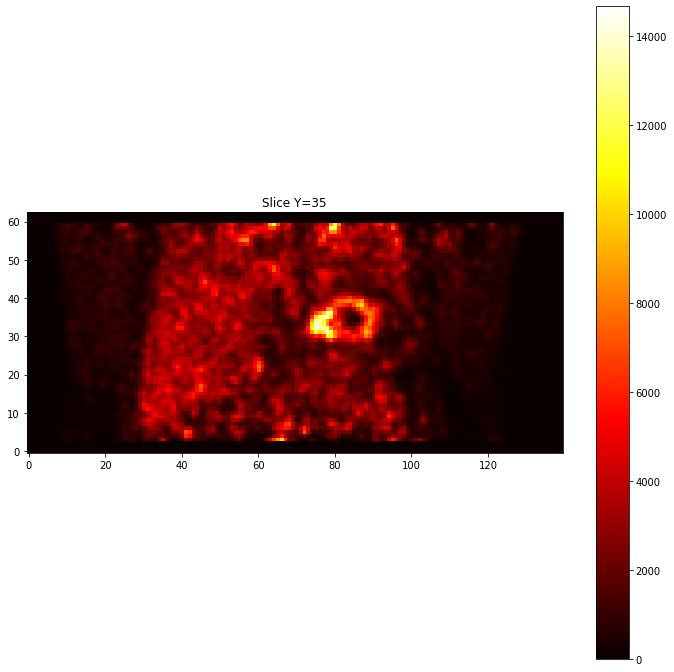

In [1]:
import numpy as np
import matplotlib.pyplot as plt


hdr_path = "/Users/yuema/MyCode/castor_v3.2/benchmark/benchmark_pet_list-mode_challenger_it2.hdr"
img_path = hdr_path.replace(".hdr", ".img")

# 1️⃣ read from the hearder
shape = []
voxel_size = []
byte_order = 'little'
dtype = None

with open(hdr_path, 'r') as f:
    for line in f:
        if "matrix size [1]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "matrix size [2]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "matrix size [3]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "number format" in line:
            fmt = line.split(":=")[-1].strip().lower()
            if "short float" in fmt:
                dtype = np.float32
            elif "long float" in fmt:
                dtype = np.float64
            elif "signed integer" in fmt:
                dtype = np.int32
            elif "unsigned integer" in fmt:
                dtype = np.uint32
        elif "imagedata byte order" in line:
            if "little" in line.lower():
                byte_order = "little"
            elif "big" in line.lower():
                byte_order = "big"

# 2️⃣ read the binary data
byteorder_prefix = "<" if byte_order == "little" else ">"
with open(img_path, "rb") as f:
    data = np.fromfile(f, dtype=byteorder_prefix + dtype().dtype.char)

# 3️⃣ reshape to 3d array
data = data.reshape(shape)


fig = plt.figure(figsize=(12, 12))
y = shape[1] // 2
plt.imshow(data[:, y, :], cmap="hot", origin="lower")
plt.title(f"Slice Y={y}")
plt.colorbar()
plt.show()


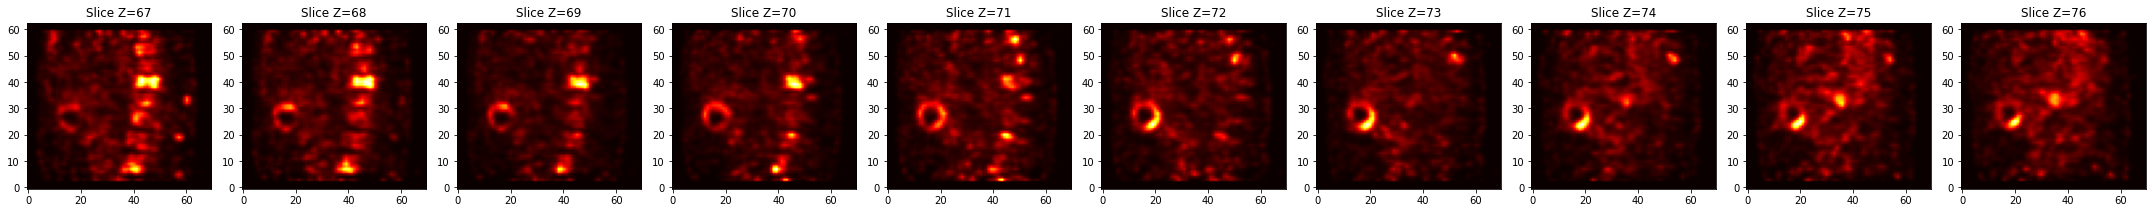

In [2]:
# plot z slices
fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i, ax in enumerate(axes):
    z = i + shape[2] // 2 - 3
    ax.imshow(data[:, :, z], cmap="hot", origin="lower")
    ax.set_title(f"Slice Z={z}")
    #plt.colorbar(ax.imshow(data[:, :, z], cmap="hot", origin="lower"), ax=ax)
plt.tight_layout()
plt.show()

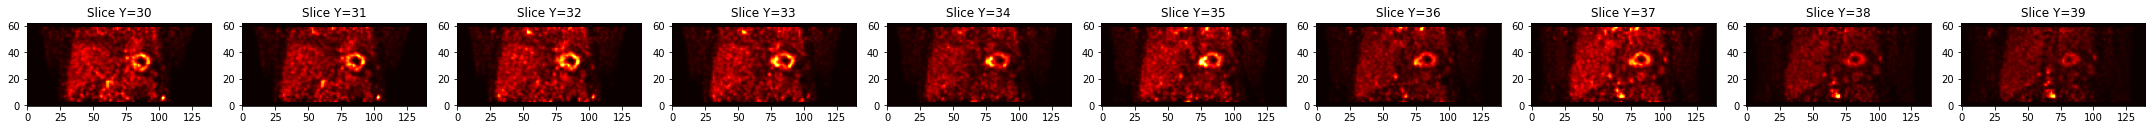

In [3]:
# plot y slices
fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i, ax in enumerate(axes):
    y = i + shape[1] // 2 - 5
    ax.imshow(data[:, y, :], cmap="hot", origin="lower")
    ax.set_title(f"Slice Y={y}")
    #plt.colorbar(ax.imshow(data[:, y, :], cmap="hot", origin="lower"), ax=ax)
plt.tight_layout()
plt.show()

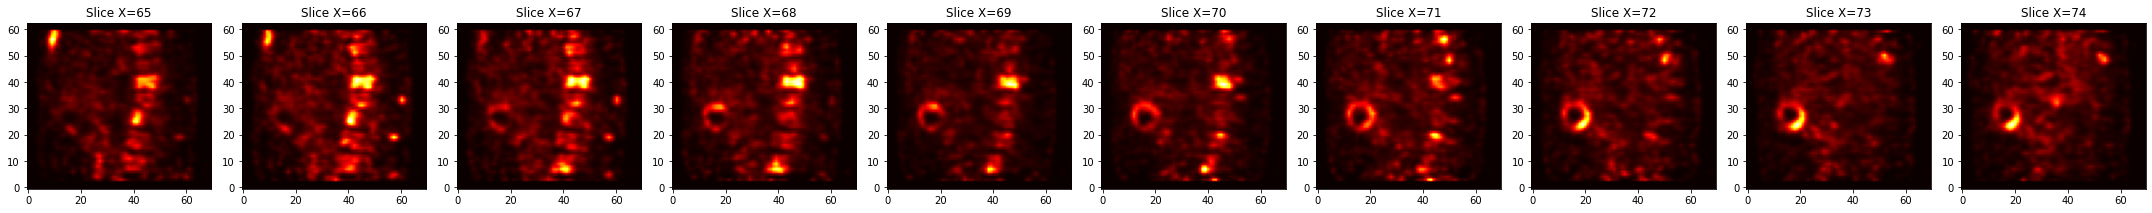

In [4]:
# plot x slices
fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i, ax in enumerate(axes):
    x = i + shape[2] // 2 - 5
    ax.imshow(data[:, :, x], cmap="hot", origin="lower")
    ax.set_title(f"Slice X={x}")
    #plt.colorbar(ax.imshow(data[:, y, :], cmap="hot", origin="lower"), ax=ax)
plt.tight_layout()
plt.show()

### Check configs and headers

In [5]:
raw_data_header = "/Users/yuema/MyCode/castor_v3.2/benchmark/benchmark_pet_list-mode_tof.cdh"
raw_data_file = "/Users/yuema/MyCode/castor_v3.2/benchmark/benchmark_pet_list-mode_tof.cdf"
config_header = "/Users/yuema/MyCode/castor_v3.2/config/scanner/PET_GE_SIGNA_PET-MR.hscan"
config_lut = "/Users/yuema/MyCode/castor_v3.2/config/scanner/PET_GE_SIGNA_PET-MR.lut"

#### Config lut

In [6]:
import numpy as np

def check_binary_lut(filepath, expected_elements=None):
    try:
        data = np.fromfile(filepath, dtype=np.float32)
        if len(data) % 6 != 0:
            raise ValueError("The binary .lut file does not contain a multiple of 6 floats per crystal.")
        num_crystals = len(data) // 6
        print(f"✅ Total crystals found: {num_crystals}")
        if expected_elements is not None and num_crystals != expected_elements:
            print(f"❌ Mismatch with expected number of elements: {expected_elements}")
        else:
            print("✅ Number of elements matches expectation.")

        # Check orientation vectors norm
        vectors = data.reshape((-1, 6))[:, 3:6]
        norms = np.linalg.norm(vectors, axis=1)
        if not np.allclose(norms, 1.0, atol=1e-2):
            print("⚠️ Warning: Some orientation vectors are not unit length (||v|| != 1).")
        else:
            print("✅ Orientation vectors look normalized.")
    except Exception as e:
        print(f"❌ Error reading binary LUT: {e}")


check_binary_lut(config_lut, expected_elements=20160)


✅ Total crystals found: 20160
✅ Number of elements matches expectation.
✅ Orientation vectors look normalized.


In [7]:
import numpy as np

def print_lut_preview(filepath, num_crystals=5):
    # read the whole file
    data = np.fromfile(filepath, dtype=np.float32)

    if len(data) % 6 != 0:
        raise ValueError("File length is not divisible by 6. Each crystal should have 6 float32 values.")

    data = data.reshape((-1, 6))
    print(f"Total crystals: {data.shape[0]}\n")
    print(f"Showing first {num_crystals} crystals:")

    for i in range(min(num_crystals, data.shape[0])):
        pos = data[i, 0:3]
        ori = data[i, 3:6]
        print(f"Crystal {i}:")
        print(f"  Position (x, y, z): {pos}")
        print(f"  Orientation (vx, vy, vz): {ori}")
        print()

# usage
print_lut_preview(config_lut, num_crystals=5)


Total crystals: 20160

Showing first 5 crystals:
Crystal 0:
  Position (x, y, z): [ -30.2625   329.5     -122.54222]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 1:
  Position (x, y, z): [ -26.2875   329.5     -122.54222]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 2:
  Position (x, y, z): [ -22.3125   329.5     -122.54222]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 3:
  Position (x, y, z): [ -18.337502  329.5      -122.54222 ]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 4:
  Position (x, y, z): [ -14.062501  329.5      -122.54222 ]
  Orientation (vx, vy, vz): [0. 1. 0.]



#### Raw data file

In [8]:
import struct 

def parse_cdh_for_event_structure(cdh_path):
    with open(cdh_path, "r") as f:
        lines = f.readlines()

    fields = [("time", "I")]  # uint32
    total_size = 4

    # Flags from the header
    flags = {line.split(":")[0].strip(): line.split(":")[1].strip() for line in lines if ":" in line}
    
    def add_field(name, fmt, size):
        fields.append((name, fmt))
        return size

    if flags.get("Attenuation correction flag", "0") == "1":
        total_size += add_field("attenuation", "f", 4)
    if flags.get("Scatter correction flag", "0") == "1":
        total_size += add_field("scatter", "f", 4)
    if flags.get("Random correction flag", "0") == "1":
        total_size += add_field("random", "f", 4)
    if flags.get("Normalization correction flag", "0") == "1":
        total_size += add_field("normalization", "f", 4)
    if flags.get("TOF information flag", "0") == "1":
        total_size += add_field("tof", "f", 4)
        if flags.get("Per event TOF resolution flag", "0") == "1":
            total_size += add_field("tof_resolution", "f", 4)

    # Always present: 2 crystal IDs
    total_size += add_field("crystal1", "I", 4)
    total_size += add_field("crystal2", "I", 4)

    format_string = "<" + "".join(fmt for _, fmt in fields)

    return fields, format_string, total_size

def read_castor_event_auto(file, i, format_string, event_size):
    file.seek(i * event_size)
    data = file.read(event_size)
    if len(data) < event_size:
        return None
    values = struct.unpack(format_string, data)
    return values

def preview_castor_cdf_auto(cdf_path, cdh_path, num_events=5):
    fields, fmt, evt_size = parse_cdh_for_event_structure(cdh_path)
    print(f"Detected structure: {fields}")
    print(f"Total event size: {evt_size} bytes")

    with open(cdf_path, "rb") as f:
        for i in range(num_events):
            result = read_castor_event_auto(f, i, fmt, evt_size)
            if result is None:
                break
            print(f"Event {i}:")
            for (name, _), val in zip(fields, result):
                print(f"  {name}: {val}")
            print()

# usage
preview_castor_cdf_auto(raw_data_file, raw_data_header, num_events=5)



Detected structure: [('time', 'I'), ('attenuation', 'f'), ('scatter', 'f'), ('random', 'f'), ('normalization', 'f'), ('tof', 'f'), ('crystal1', 'I'), ('crystal2', 'I')]
Total event size: 32 bytes
Event 0:
  time: 830956
  attenuation: 24.09225082397461
  scatter: 2.1628741819768038e-07
  random: 0.00010076240141643211
  normalization: 1.2539879083633423
  tof: -624.9600219726562
  crystal1: 631
  crystal2: 7108

Event 1:
  time: 830956
  attenuation: 16.687414169311523
  scatter: 2.2032646995739924e-07
  random: 0.00011687124788295478
  normalization: 1.1026785373687744
  tof: -807.2400512695312
  crystal1: 14939
  crystal2: 7140

Event 2:
  time: 830956
  attenuation: 12.581854820251465
  scatter: 5.714462645300955e-07
  random: 0.00011404224642319605
  normalization: 1.3658506870269775
  tof: -117.18000793457031
  crystal1: 1808
  crystal2: 7435

Event 3:
  time: 830956
  attenuation: 13.115365982055664
  scatter: 4.117372895962035e-07
  random: 0.00011505995644256473
  normalization